<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_1_single_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Single Layer LSTM

So far in this course, you've been using mostly basic dense layers and embeddings to build your models. It detects how the combination of words (or subwords) in the input text determines the output class. In the labs this week, you will look at other layers you can use to build your models. Most of these will deal with *Recurrent Neural Networks*, a kind of model that takes the ordering of inputs into account. This makes it suitable for different applications such as parts-of-speech tagging, music composition, language translation, and the like. For example, you may want your model to differentiate sentiments even if the words used in two sentences are the same:

```
1: My friends do like the movie but I don't. --> negative review
2: My friends don't like the movie but I do. --> positive review
```

The first layer you will be looking at is the [*LSTM (Long Short-Term Memory)*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In a nutshell, it computes the state of a current timestep and passes it on to the next timesteps where this state is also updated. The process repeats until the final timestep where the output computation is affected by all previous states. Not only that, it can be configured to be bidirectional so you can get the relationship of later words to earlier ones. If you want to go in-depth of how these processes work, you can look at the [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course of the Deep Learning Specialization. For this lab, you can take advantage of Tensorflow's APIs that implements the complexities of these layers for you. This makes it easy to just plug it in to your model. Let's see how to do that in the next sections below. 

In [ ]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

## Download the dataset

For this lab, you will use the `subwords8k` pre-tokenized [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews). You will load it via Tensorflow Datasets as you've done last week:

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features["text"].encoder

/Users/elliottevans/miniforge3/envs/tf_py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M1


2022-11-24 17:50:02.400489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 17:50:02.400636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Prepare the dataset

You can then get the train and test splits and generate padded batches. 

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = (
    dataset["train"],
    dataset["test"],
)

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

In [3]:
# Take 2 training examples and decode the text feature
for example in test_data.take(3):
    print(f'SENTENCE:\n{tokenizer.decode(example[0])}')
    print(f'SEQ LEN: {len(example[0])}')
    print(f'CLASSIFICATION: {example[1].numpy()}\n\n')


2022-11-24 17:50:06.300652: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


SENTENCE:
There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.
SEQ LEN: 283
CLASSIFICATION: 1


SENTENCE:
A black

2022-11-24 17:50:06.544130: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Build and compile the model

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [4]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=tokenizer.vocab_size, 
            output_dim=embedding_dim
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                lstm_dim,
                activation='tanh',  # for memory cell state & hidden state activations
                recurrent_activation='sigmoid'  # for input / forget / output gates
            )
        ),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Set the training parameters
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Train the model

Now you can start training. Using the default parameters above, you should reach around 98% training accuracy and 82% validation accuracy. You can visualize the results using the same plot utilities. See if you can still improve on this by modifying the hyperparameters or by training with more epochs.

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10


2022-11-24 17:50:15.554335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 17:50:15.988854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 17:50:16.030088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 17:50:28.229776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 17:50:28.253750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/98 [..............................] - ETA: 1:15:06 - loss: 0.6947 - accuracy: 0.4870

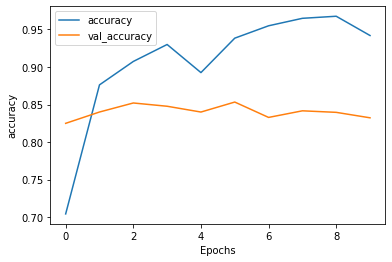

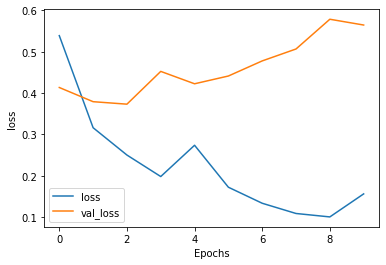

In [8]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you got a first look at using LSTM layers to build Recurrent Neural Networks. You only used a single LSTM layer but this can be stacked as well to build deeper networks. You will see how to do that in the next lab.